<a href="https://colab.research.google.com/github/raghadenawar23/Coursework-Assignment-1-raghade-nawar-19101522.ipynb/blob/main/Coursework_Assignment_1_raghade_nawar_19101522.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RBM Project

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import os
import numpy as np
import keras
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

Download the dataset

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

In [ ]:
def sample(probabilities, mode='bernoulli'):
    ''' Sample a tensor based on the probabilities (A tensor given by get_probabilities)'''
    if mode=='bernoulli':
        return tf.floor(probabilities + tf.random.uniform(tf.shape(probabilities), 0, 1))
    elif mode=='gaussian':
        return tf.add(probabilities, tf.random.normal(tf.shape(probabilities), mean=0.0, stddev=1.)) # Add noise to the original probabilities



# Simple RBM class
class RBM:

    def __init__(self, n_visible, n_hidden, lr, epochs, mode='bernoulli'):
        ''' Initialize a model for an RBM with one layer of hidden units '''
        self.mode = mode # bernoulli or gaussian RBM
        self.n_hidden = n_hidden #  Number of hidden nodes
        self.n_visible = n_visible # Number of visible nodes
        self.lr = lr # Learning rate for the CD algorithm
        self.epochs = epochs # Number of iterations to run the algorithm for

        # Initialize weights and biases
        with tf.name_scope('Weights'):
            self.W = tf.Variable(tf.random.normal([self.n_visible, self.n_hidden], mean=0., stddev=4 * np.sqrt(6. / (self.n_visible + self.n_hidden))), name="weights")
        self.vb = tf.Variable(tf.zeros([1, self.n_visible]),tf.float32, name="visible_bias")
        self.hb = tf.Variable(tf.zeros([1, self.n_hidden]),tf.float32, name="hidden_bias")


    def get_probabilities(self, layer, val):
        ''' Return a tensor of probabilities associated with the layer specified'''
        if layer == 'hidden':
            with tf.name_scope("Hidden_Probabilities"):
                if self.mode=='bernoulli':
                    return tf.nn.sigmoid(tf.matmul(val, self.W) + self.hb)
                elif self.mode=='gaussian':
                    return tf.matmul(val, self.W) + self.hb

        elif layer == 'visible':
            with tf.name_scope("Visible_Probabilities"):
                return tf.nn.sigmoid(tf.matmul(val, tf.transpose(self.W)) + self.vb)


    def CD(self, v, K=1):
        ''' K-step Contrastive Divergence using Gibbs sampling. Return parameters update. '''
        with tf.name_scope("Contrastive_Divergence"):
            h_prob = self.get_probabilities('hidden', v)
            h_state = sample(h_prob, mode=self.mode)
            pos_divergence = tf.matmul(tf.transpose(v), h_prob) # Positive Divergence + h(v).v^T

            fake_v_prob = self.get_probabilities('visible', h_state)
            fake_v_state = fake_v_prob #sample(fake_v_prob)

            fake_h_prob = self.get_probabilities('hidden', fake_v_state)
            fake_h_state = sample(fake_h_prob, mode=self.mode)

            for i in range(K-1): # Number of steps to run the algorithm

                fake_v_prob = self.get_probabilities('visible', fake_h_state)
                fake_v_state = fake_v_prob #sample(fake_v_prob)

                fake_h_prob = self.get_probabilities('hidden', fake_v_state)
                fake_h_state = sample(fake_h_prob, mode=self.mode)

            neg_divergence = tf.matmul(tf.transpose(fake_v_state), fake_h_prob) # Negative Divergence - h(v').v'^T

            dW = pos_divergence-neg_divergence
            dvb = v-fake_v_state
            dhb = h_prob-fake_h_prob

            # Similarity between reconstructed visible layer and input during training.
            self.rec_error = tf.reduce_mean(tf.squared_difference(v, fake_v_state))

            self.div = tf.reduce_mean(tf.abs(dW))

            return dW, dvb, dhb


    def update(self, v, K=1):
        batch_size = tf.cast(tf.shape(v)[0], tf.float32) # batch size
        dW, dvb, dhb = self.CD(v, K=K) # contrastive divergence

        delta_w = (self.lr/batch_size)*dW # weight gradient
        delta_vb = (self.lr/batch_size)*(tf.reduce_sum(dvb, 0, keepdims =True)) # visible bias gradient
        delta_hb = (self.lr/batch_size)*(tf.reduce_sum(dhb, 0, keepdims =True)) # hidden bias gradient

        train_op = [self.W.assign_add(delta_w), self.vb.assign_add(delta_vb), self.hb.assign_add(delta_hb)]
        return train_op


    def gibbs(self, steps, v):
        ''' Use the Gibbs sampler for a network of hidden and visible units. Return a sampled version of the input'''
        with tf.name_scope("Gibbs_sampling"):
            for i in range(steps): # Number of steps to run the algorithm
                hidden_p = self.get_probabilities('hidden', v) # v: input data
                h = sample(hidden_p, mode=self.mode)

                visible_p = self.get_probabilities('visible', h)
                v = visible_p
                #v = sample(visible_p)
            return visible_p


    def get_feature_map(self):
        ''' Return hidden features'''
        ft_map = {}
        for k in range(self.n_hidden):
            ft_map[k] = self.get_probabilities('visible', tf.expand_dims(tf.one_hot(k+1, self.n_hidden),0))
        return ft_map

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
# Initialize RBM Model for MNIST reconstruction
rbm_model = RBM(n_visible = 784, n_hidden = 144, lr = tf.constant(0.05, tf.float32), epochs = 5, mode='bernoulli')
# Placeholder for the visible layer of the RBM computation graph.
v = tf.placeholder(tf.float32, shape=[None, rbm_model.n_visible], name="visible_layer")

In [ ]:
x_train = x_train.reshape(x_train.shape[0], -1) / 255.
x_test = x_test.reshape(x_test.shape[0], -1) / 255.
print(x_train.shape, x_test.shape)

In [ ]:
# Update rule
k=1
train_op = rbm_model.update(v, K=k)

In [ ]:
# Create session.
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [ ]:
def show_digit(original, fake):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.imshow(original.reshape((28,28)),cmap = plt.cm.gray)
    ax1.set_title('Original photo')
    ax2.imshow(fake.reshape((28,28)),cmap = plt.cm.gray)
    ax2.set_title('Sampled photo')
    plt.show()

<ipython-input-9-02b37f983ad9>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(rbm_model.epochs)):


  0%|          | 0/5 [00:00<?, ?it/s]

Reconstruction error at step 0: 0.270


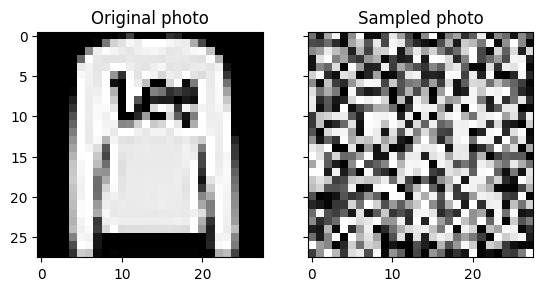

<ipython-input-9-02b37f983ad9>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_ind in tqdm_notebook(range(0, len(x_train), batch_size)): # 0 32/ 32 64/ ...


  0%|          | 0/1875 [00:00<?, ?it/s]

Reconstruction error at step 1: 0.041


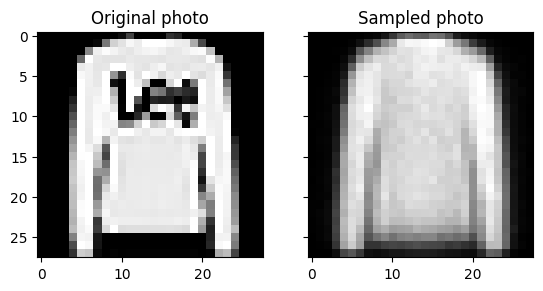

  0%|          | 0/1875 [00:00<?, ?it/s]

Reconstruction error at step 2: 0.038


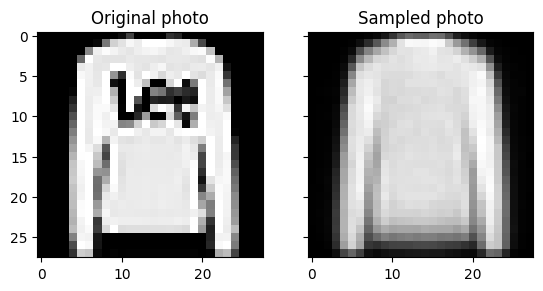

  0%|          | 0/1875 [00:00<?, ?it/s]

Reconstruction error at step 3: 0.034


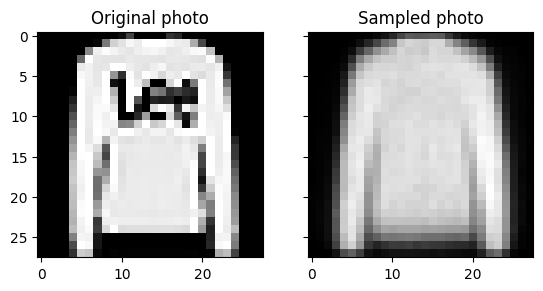

  0%|          | 0/1875 [00:00<?, ?it/s]

Reconstruction error at step 4: 0.029


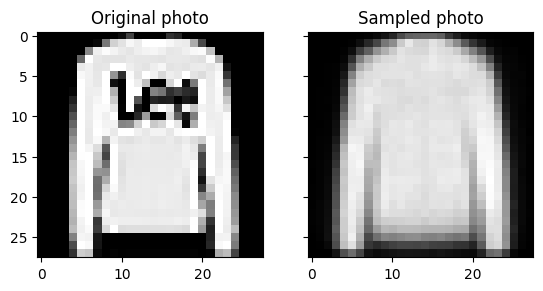

  0%|          | 0/1875 [00:00<?, ?it/s]

In [ ]:
batch_size = 32

for epoch in tqdm_notebook(range(rbm_model.epochs)):
    result = sess.run([rbm_model.rec_error], feed_dict = {v: x_test})
    print("Reconstruction error at step {}: {:.3f}".format(epoch, result[0]))
    test_image = x_test[1] # from test distribution
    sample_test = rbm_model.gibbs(1, v=v).eval(session=sess, feed_dict={v: test_image.reshape(1,-1).astype(np.float32)})
    show_digit(original=test_image, fake=sample_test)
    for batch_ind in tqdm_notebook(range(0, len(x_train), batch_size)): # 0 32/ 32 64/ ...
        next_batch = batch_ind + batch_size
        batchXs = x_train[batch_ind:next_batch]
        sess.run(train_op, feed_dict = {v: batchXs})

Table

In [ ]:
def plot_features(ft_map):
    """ Plot MNIST features in a table."""
    len_ = int(np.sqrt(rbm_model.n_hidden))
    fig = plt.figure()
    features = [ft_map[k] for k in range(rbm_model.n_hidden)]
    for x in range(len_):
        for y in range(len_):
            ax = fig.add_subplot(len_, len_, len_*y+x+1)
            ax.matshow(features[len_*y+x].reshape((28,28)), cmap = plt.cm.gray)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
    plt.show()

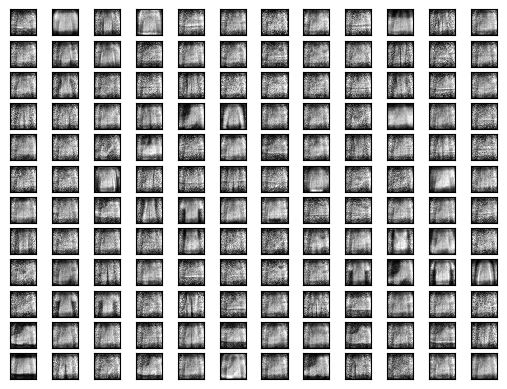

In [ ]:
ft_map = sess.run(rbm_model.get_feature_map())
plot_features(ft_map)

Training

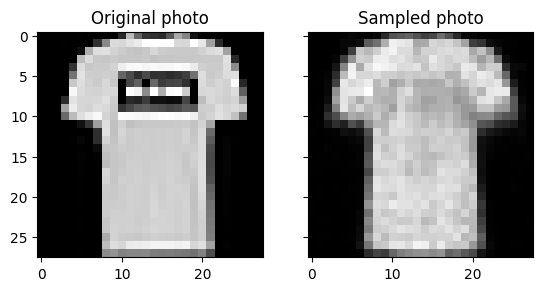

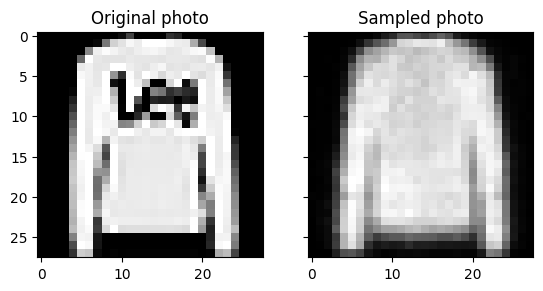

In [ ]:
train_image = x_train[1] # from train distribution
sample_train = rbm_model.gibbs(1, v=v).eval(session=sess, feed_dict={v: train_image.reshape(1,-1).astype(np.float32)})
show_digit(original=train_image, fake=sample_train)

test_image = x_test[1] # from test distribution
sample_test = rbm_model.gibbs(1, v=v).eval(session=sess, feed_dict={v: test_image.reshape(1,-1).astype(np.float32)})
show_digit(original=test_image, fake=sample_test)

tf.reset_default_graph()

**MLP**

In [ ]:
class MLP(tf.keras.Model):
    def __init__(self, num_hidden):
        super(MLP, self).__init__()
        self.num_hidden = num_hidden
        self.hidden_layer = tf.keras.layers.Dense(num_hidden, activation='relu')
        self.output_layer = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, inputs):
        hidden = self.hidden_layer(inputs)
        output = self.output_layer(hidden)
        return output

**RBM Loss**

In [ ]:
# Define the loss functions
def rbm_loss(model, x):
    visible, hidden = model(x)
    energy1 = model.energy(x, hidden)
    visible2, _ = model(hidden)
    energy2 = model.energy(visible2, hidden)
    return tf.reduce_mean(energy1 - energy2)

**MLP Loss**

In [ ]:
def mlp_loss(model, x, y):
    y_pred = model(x)
    return tf.keras.losses.sparse_categorical_crossentropy(y, y_pred)

**Training**

In [ ]:
def train(model, x_train, y_train, x_test, y_test, num_epochs, batch_size, learning_rate):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    train_loss = tf.keras.metrics.Mean()
    test_loss = tf.keras.metrics.Mean()
    train_acc = tf.keras.metrics.SparseCategoricalAccuracy()
    test_acc = tf.keras.metrics.SparseCategoricalAccuracy()

    for epoch in range(num_epochs):
        for i in range(0, len(x_train), batch_size):
            x_batch = x_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            with tf.GradientTape() as tape:
                loss = model.loss(x_batch, y_batch)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        train_loss.reset_states()
        test_loss.reset_states()
        train_acc.reset_states()
        test_acc.reset_states()

        train_loss.update_state(model.loss(x_train, y_train))
        test_loss.update_state(model.loss(x_test, y_test))
        train_acc.update_state(y_train, model(x_train))
        test_acc.update_state(y_test, model(x_test))

        print(f'Epoch {epoch+1}, '
              f'Train Loss: {train_loss.result():.4f}, '
              f'Test Loss: {test_loss.result():.4f}, '
              f'Train Acc: {train_acc.result():.4f}, '
              f'Test Acc: {test_acc.result():.4f}')

# Train the RBM model
rbm = RBM(n_hidden=64,n_visible=64,lr=0.001, epochs=10)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

for epoch in range(10):
    for i in range(0, len(x_train), 256):
        x_batch = x_train[i:i+256]
        with tf.GradientTape() as tape:
            loss = rbm_loss(rbm, x_batch)
        gradients = tape.gradient(loss, rbm.trainable_variables)
        optimizer.apply_gradients(zip(gradients, rbm.trainable_variables))

# Extract the hidden layer from the RBM model
x_train_hidden, _ = rbm(x_train)
x_test_hidden, _ = rbm(x_test)

# Train the MLP with the RBM hidden layer
mlp_rbm = MLP(num_hidden=64)
train(mlp_rbm, x_train_hidden, y_train, x_test_hidden, y_test, num_epochs=10, batch_size=256, learning_rate=0.001)

# Train the MLP with the raw images
mlp_raw = MLP(num_hidden=64)
train(mlp_raw, x_train, y_train, x_test, y_test, num_epochs=10, batch_size=256, learning_rate=0.001)

TypeError: ignored